In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sparse_shift.plotting import plot_dag
from collections import defaultdict

In [14]:
SIM_NAME = 'bivariate_cdnod'
df = pd.read_csv(f'./{SIM_NAME}_pvalues.csv', header=[0, 1], delimiter=', ', engine='python')

In [75]:
dag2mech = {
    'XY': {
        'X1': 'PA=(X2)',
        'X2': 'PA=()'
    },
    'YX': {
        'X1': 'PA=()',
        'X2': 'PA=(X1)'
    }
}

In [144]:
alpha = 0.05
dfs = []
for dag_key in dag2mech.keys():
    for variable, mech in dag2mech[dag_key].items():
        power_df = df['Params']
        power_df.loc[:, 'variable'] = variable
        power_df.loc[:, 'mechanism'] = mech
        power_df.loc[:, 'test_power'] = (df[dag_key][variable] <= alpha).astype(int)
        dfs.append(power_df)
        
power_df = pd.concat(dfs, axis=0)

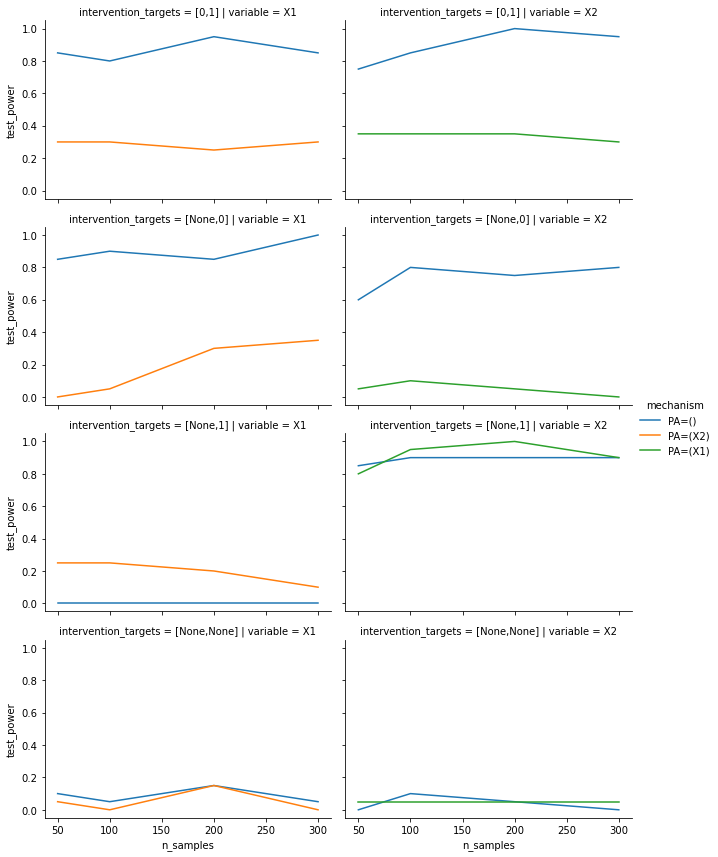

In [162]:
sns.relplot(
    data=power_df.groupby(
        ['intervention_targets', 'n_samples', 'variable', 'mechanism']
    ).mean().reset_index(),
    x='n_samples',
    y='test_power',
    col='variable',
    row='intervention_targets',
    hue='mechanism',
    kind='line',
    height=3, aspect=1.5,
    legend='full',
)
plt.show()

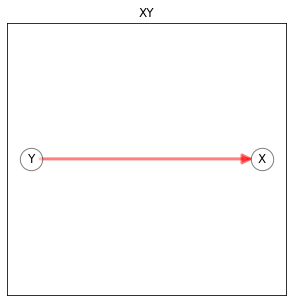

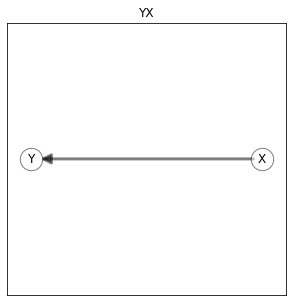

In [16]:
dag_dict = {
    'XY': np.asarray([[0, 1], [0, 0]]),
    'YX': np.asarray([[0, 0], [1, 0]])
}

true_parents = dag_dict['YX']

for key, dag in dag_dict.items():
    plot_dag(
        dag,
        highlight_edges=dag-true_parents,
        labels=['X', 'Y'],
        title=key)

In [46]:
df = pd.read_csv(f'./{SIM_NAME}_pvalues.csv', header=[0, 1], delimiter=', ', engine='python')

n_features = 2
alpha = 0.05 / n_features

n_samples_list = df['Params']['n_samples'].unique()
change_counts = {
    params_key: {
        dag_key : []
        for dag_key in dag_dict.keys()
    }
    for params_key in df['Params']['params_index'].unique()
}

for params_index in df['Params']['params_index'].unique():
    sub_df = df[df['Params']['params_index'] == params_index]
    targets = sub_df['Params', 'intervention_targets'].iloc[0]
    print('Params index: ', params_index,' Targets: ', targets)
    
    for i, n_samples in enumerate(n_samples_list):
        idx = sub_df[sub_df['Params']['n_samples'] == n_samples].index
        
        for dag_key in dag_dict.keys():
            change_counts[params_index][dag_key].append(np.sum(
                sub_df.loc[idx][dag_key].to_numpy() < alpha, axis=1
            ))

Params index:  0  Targets:  [None,0]
Params index:  1  Targets:  [None,1]
Params index:  2  Targets:  [None,None]
Params index:  3  Targets:  [0,1]


In [47]:
change_counts

{0: {'XY': [array([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1]),
   array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]),
   array([0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]),
   array([1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1])],
  'YX': [array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]),
   array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]),
   array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0]),
   array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]},
 1: {'XY': [array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1]),
   array([1, 2, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]),
   array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
   array([1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1])],
  'YX': [array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1]),
   array([1, 1, 1, 1, 1, 0, 1,

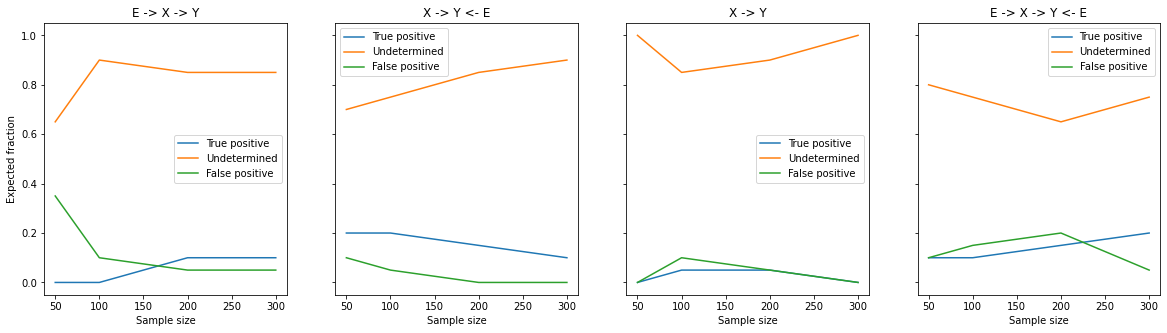

In [48]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

for col, target in enumerate(change_counts.keys()):
    ax = axes[col]
    
    count_diffs = np.asarray(change_counts[target]['XY']) - np.asarray(change_counts[target]['YX'])
    ax.plot(
        n_samples_list,
        np.mean(count_diffs > 0, axis=1),
        label='True positive'
    )
    
    ax.plot(
        n_samples_list,
        np.mean(count_diffs == 0, axis=1),
        label='Undetermined'
    )
    
    ax.plot(
        n_samples_list,
        np.mean(count_diffs < 0, axis=1),
        label='False positive'
    )
    
    if target == 0:
        ax.set_title('E -> X -> Y')  
    elif target == 1:
        ax.set_title('X -> Y <- E') 
    elif target == 2:
        ax.set_title('X -> Y') 
    elif target == 3:
        ax.set_title('E -> X -> Y <- E')  
    ax.set_xlabel('Sample size')
    ax.legend()
axes[0].set_ylabel('Expected fraction')
plt.show()